# Jacobi and Conjugate Gradient Methods

### We'll start off by importing what we need

In [2]:
import os
import math

import numpy as np
import numpy.linalg as npla

import scipy
import scipy.sparse.linalg as spla
from scipy import sparse
from scipy import linalg

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [3]:
def Jsolve(A, b, tol = 1e-8, max_iters = 1000, callback = None):
    """Solve a linear system Ax = b for x by the Jacobi iterative method.
    Parameters: 
      A: the matrix.
      b: the right-hand side vector.
      tol = 1e-8: the relative residual at which to stop iterating.
      max_iters = 1000: the maximum number of iterations to do. 
      callback = None: a user function to call at every iteration. 
        The callback function has arguments 'x', 'iteration', and 'residual'
    Outputs (in order):
      x: the computed solution
      rel_res: list of relative residual norms at each iteration.
        The number of iterations actually done is len(rel_res) - 1
    """
    # Check the input
    m, n = A.shape
    assert m == n, "matrix must be square"
    bn, = b.shape
    assert bn == n, "rhs vector must be same size as matrix"

    # Split A into diagonal D plus off-diagonal C
    d = A.diagonal()         # diagonal elements of A as a vector
    C = A.copy()             # copy of A ...
    C.setdiag(np.zeros(n))   # ... without the diagonal
    
    # Initial guess: x = 0
    x = np.zeros(n)

    # Vector of relative residuals
    # Relative residual is norm(residual)/norm(b)
    # Intitial residual is b - Ax for x=0, or b
    rel_res = [1.0]
        
    # Call user function if specified
    if callback is not None:
        callback(x = x, iteration = 0, residual = 1)

    # Iterate
    for k in range(1, max_iters+1):
        # New x
        x = (b - C @ x) / d

        # Record relative residual
        this_rel_res = npla.norm(b - A @ x) / npla.norm(b)
        rel_res.append(this_rel_res)
                
        # Call user function if specified
        if callback is not None:
            callback(x = x, iteration = k, residual = this_rel_res)
                        
        # Stop if within tolerance    
        if this_rel_res <= tol:
            break
            
    return (x, rel_res)

In [4]:
def CGsolve(A, b, tol = 1e-8, max_iters = 1000, callback = None):
    """Solve a linear system Ax = b for x by the conjugate gradient iterative method.
    Parameters: 
      A: the matrix.
      b: the right-hand side vector.
      tol = 1e-8: the relative residual at which to stop iterating.
      max_iters = 1000: the maximum number of iterations to do. 
      callback = None: a user function to call at every iteration, with one argument x
    Outputs (in order):
      x: the computed solution
      rel_res: list of relative residual norms at each iteration.
        The number of iterations actually done is len(rel_res) - 1
    """
    # Check the input
    m, n = A.shape
    assert m == n, "matrix must be square"
    bn, = b.shape
    assert bn == n, "rhs vector must be same size as matrix"

    # Initial guess: x = 0
    x = np.zeros(n)
    
    # Initial residual: r = b - A@0 = b
    r = b
 
    # Initial step is in direction of residual.
    d = r

    # Squared norm of residual
    rtr = r.T @ r
    
    # Vector of relative residuals
    # Relative residual is norm(residual)/norm(b)
    # Intitial residual is b - Ax for x=0, or b
    rel_res = [1.0]
     
    # Call user function if specified
    if callback is not None:
        callback(x = x, iteration = 0, residual = 1)

    # Iterate
    for k in range(1, max_iters+1):
        Ad = A @ d
        alpha = rtr / (d.T @ Ad)  # Length of step
        x = x + alpha * d         # Update x to new x
        r = r - alpha * Ad        # Update r to new residual
        rtrold = rtr 
        rtr = r.T @ r
        beta = rtr / rtrold    
        d = r + beta * d          # Update d to new step direction
                   
        # Record relative residual
        this_rel_res = npla.norm(b - A @ x) / npla.norm(b)
        rel_res.append(this_rel_res)
                
        # Call user function if specified
        if callback is not None:
            callback(x = x, iteration = k, residual = this_rel_res)
                        
        # Stop if within tolerance    
        if this_rel_res <= tol:
            break
            
    return (x, rel_res)

# Re: Jacobi's Method

In [5]:
A = np.array([[4, -1, -1], [-2, 6, 1], [-1, 1, 7]])
b = np.array([3, 9, -6])
print("A:\n", A)
print("\nb:\n", b)

x = npla.solve(A, b)
print("\nIdeal x (so we can compare against it):\n", x)

A:
 [[ 4 -1 -1]
 [-2  6  1]
 [-1  1  7]]

b:
 [ 3  9 -6]

Ideal x (so we can compare against it):
 [ 1.  2. -1.]


In [6]:
#Run it using Jacobi
# IMPORTANT NOTE: Jsolve() requires A to be a sparse matrix
A = sparse.csr_matrix(A)

# Remember: JSolve() returns the x vector 
# AND a vector of all the iterated residual norms (a nice way to keep track)
#
# NOTE: The function Jsolve() has a default setting for "tolerance" (i.e. accuracy) at 1e-8,
# you can change that with option tol=...
#

x, res = Jsolve(A,b)
print("x and iterated residuals: \n", x, '\n', res)

# To see the last residual:
print("\n\nLast residual: ", res[-1])

# To see how many iterations:
print("Number of iterations is:", len(res) - 1)

x and iterated residuals: 
 [ 1.00000001  1.99999999 -1.        ] 
 [1.0, 0.22768482384372116, 0.0503319479919278, 0.01604740441421596, 0.0035829971654077523, 0.001601864415303465, 0.00040285328778971074, 0.00021399546675719867, 6.959176731826758e-05, 3.4601335035126733e-05, 1.3174531968220623e-05, 6.075146130834141e-06, 2.4796394112400105e-06, 1.099349933223233e-06, 4.620206634338095e-07, 2.0119957277470704e-07, 8.561022957943247e-08, 3.698871997266093e-08, 1.5822059686393463e-08, 6.8127044622987766e-09]


Last residual:  6.8127044622987766e-09
Number of iterations is: 19


# CG Method on a NON-SPD matrix

In [29]:
A = np.array([[4, -1, -1], [-2, 6, 1], [-1, 1, 7]])
print(A)
# IS A SPD?
print(np.all(npla.eig(A)[0] > 0))
print(np.all(A == A.T))

u,sigma,vt = npla.svd(A,full_matrices = False)
print(u)
print(sigma)
print(vt)
B = np.zeros(3)
for n in range(3):
    B = B + sigma[n] * np.outer(u[:,n], vt[n,:])

print("B: \n", B)

[[ 4 -1 -1]
 [-2  6  1]
 [-1  1  7]]
True
False
[[-0.34688371 -0.204314   -0.91538379]
 [ 0.58541376  0.71536032 -0.38151061]
 [ 0.7327772  -0.66821808 -0.12853862]]
[8.28637719 5.59219533 3.17227116]
[[-0.39717472  0.55417987  0.73153053]
 [-0.28249345  0.68457155 -0.67198157]
 [-0.87318365 -0.47354668 -0.11534233]]
B: 
 [[ 4. -1. -1.]
 [-2.  6.  1.]
 [-1.  1.  7.]]


In [8]:
# Ok... let's see the solution for Ax = b, given:

b = np.array([3, 9, -6])

print("A:\n", A)
print("\nb:\n", b)

x = npla.solve(A, b)
print("\nx:\n", x)

A:
 [[ 4 -1 -1]
 [-2  6  1]
 [-1  1  7]]

b:
 [ 3  9 -6]

x:
 [ 1.  2. -1.]


In [9]:
x_cg, res = CGsolve(A, b)
print(x_cg, '\n')
print(res, '\n')
print("Number of iterations =", len(res) - 1)

[ 1.00000016  2.00000016 -1.00000002] 

[1.0, 0.1620339114130282, 0.056255881384691966, 0.012641623979466771, 0.0003656450913279046, 0.00013210332720754695, 3.71543825513586e-05, 8.641914496098262e-06, 4.850238673739686e-06, 1.657371953299595e-06, 8.75526390201615e-07, 6.815346033700864e-07, 3.672576846602502e-07, 2.2434054341701634e-07, 1.9600973211018295e-07, 1.6325912151083814e-07, 1.0684131853279836e-07, 7.532260789330364e-08, 6.946802953116778e-08, 6.84743547735782e-08, 5.6078668008498654e-08, 4.122430522947482e-08, 3.334804199043325e-08, 3.226877561617156e-08, 3.388828411780135e-08, 3.2984805603292395e-08, 2.83912401935978e-08, 2.3263857529430697e-08, 2.0041355952047018e-08, 1.9207644604497005e-08, 2.0161146946698055e-08, 2.1590034290935632e-08, 2.1962430234914503e-08, 2.067297404550558e-08, 1.8408352206295514e-08, 1.6215221356077753e-08, 1.4746879344005141e-08, 1.4209960054535323e-08, 1.4528226787266472e-08, 1.542897605815536e-08, 1.647370142261643e-08, 1.7163736221947576e-08, 1

## Let's put in an SPD matrix for A this time!
#### Will show you how FAST the CG Method is...!

In [10]:
# Using a SPD Matrix for A
A = np.array([[2,1],[1,1]])

# IS A SPD?
if (np.all(npla.eig(A)[0] > 0) and (np.all(A == A.T))):
    print("A is SPD matrix")
else:
    print("Caution: A is not SPD matrix")


b = np.array([1,1])
x = npla.solve(A, b)
print("\nx:\n", x)

A is SPD matrix

x:
 [0. 1.]


In [11]:
# Run CG on this:
A = sparse.csr_matrix(A)

x_cg, res = CGsolve(A, b)
print(x_cg, '\n')
print(res, '\n')
print("Number of iterations =", len(res) - 1)

[-2.77555756e-16  1.00000000e+00] 

[1.0, 0.2, 5.661048867003676e-16] 

Number of iterations = 2


In [12]:
# Using another SPD Matrix for A
A = np.array([[4, 1, -1], [1, 3, 1], [-1, 1, 3]])

# IS A SPD?
if (np.all(npla.eig(A)[0] > 0) and (np.all(A == A.T))):
    print("A is SPD matrix")
else:
    print("Caution: A is not SPD matrix")

b = 10*np.random.rand(3)
x = npla.solve(A, b)
print("\nx:\n", x)

A is SPD matrix

x:
 [ 4.38893709 -3.11234156  5.41139145]


In [13]:
A = sparse.csr_matrix(A)

x_cg, res = CGsolve(A, b)
print(x_cg, '\n')
print(res, '\n')
print("Number of iterations =", len(res) - 1)

[ 4.38893709 -3.11234156  5.41139145] 

[1.0, 0.5811441011134679, 0.13002532848049536, 1.4129458450253562e-16] 

Number of iterations = 3


In [14]:
# Let's compare with Jacobi
x_j, res = Jsolve(A, b)
print(x_j, '\n')
print(res, '\n')
print("Number of iterations =", len(res) - 1)

[ 4.38893705 -3.11234151  5.41139141] 

[1.0, 0.49509059176317227, 0.2936371442707993, 0.17315006116898612, 0.10539729220310658, 0.06376559667661119, 0.038781447588438996, 0.023547559354832378, 0.014311464501166143, 0.008694846317350464, 0.005283483473298693, 0.0032102944314210467, 0.0019506773042520385, 0.001185274581104722, 0.0007202043637994265, 0.0004376138761463883, 0.00026590535110354645, 0.00016157076277036536, 9.817447938802217e-05, 5.965328691491036e-05, 3.624684220115395e-05, 2.2024495219181087e-05, 1.3382638773271211e-05, 8.131628794239932e-06, 4.9409827270036815e-06, 3.0022657079790937e-06, 1.8242523571587807e-06, 1.1084617371731397e-06, 6.735293052928677e-07, 4.092533913640419e-07, 2.486726813881731e-07, 1.510997923596608e-07, 9.181204420926979e-08, 5.578731353118678e-08, 3.389777857177339e-08, 2.0597145007575574e-08, 1.2515344852189355e-08, 7.604639050319339e-09] 

Number of iterations = 37


# Let's do the temperature problem with Jacobi and CG!

In [15]:
def make_A(k):
    """Create the matrix for the temperature problem on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
    Outputs:
      A: the sparse k**2-by-k**2 matrix representing the finite difference approximation to Poisson's equation.
    """
    # First make a list with one triple (row, column, value) for each nonzero element of A
    triples = []
    for i in range(k):
        for j in range(k):
            # what row of the matrix is grid point (i,j)?
            row = j + i*k
            # the diagonal element in this row
            triples.append((row, row, 4.0))
            # connect to left grid neighbor
            if j > 0:
                triples.append((row, row - 1, -1.0))
            # ... right neighbor
            if j < k - 1:
                triples.append((row, row + 1, -1.0))
            # ... neighbor above
            if i > 0:
                triples.append((row, row - k, -1.0))
            # ... neighbor below
            if i < k - 1:
                triples.append((row, row + k, -1.0))
    
    # Finally convert the list of triples to a scipy sparse matrix
    ndim = k*k
    rownum = [t[0] for t in triples]
    colnum = [t[1] for t in triples]
    values = [t[2] for t in triples]
    A = sparse.csr_matrix((values, (rownum, colnum)), shape = (ndim, ndim))
    
    return A 

In [16]:
def make_b(k, top = 0, bottom = 0, left = 0, right = 0):
    """Create the right-hand side for the temperature problem on a k-by-k grid.
    Parameters: 
      k: number of grid points in each dimension.
      top: list of k values for top boundary (optional, defaults to 0)
      bottom: list of k values for bottom boundary (optional, defaults to 0)
      left: list of k values for top boundary (optional, defaults to 0)
      right: list of k values for top boundary (optional, defaults to 0)
    Outputs:
      b: the k**2 element vector (as a numpy array) for the rhs of the Poisson equation with given boundary conditions
    """
    # Start with a vector of zeros
    ndim = k*k
    b = np.zeros(shape = ndim)
    
    # Fill in the four boundaries as appropriate
    b[0        : k       ] += top
    b[ndim - k : ndim    ] += bottom
    b[0        : ndim : k] += left
    b[k-1      : ndim : k] += right
    
    return b

In [17]:
def radiator(k, width = .3, temperature = 100.):
    """Create one wall with a radiator
    Parameters: 
      k: number of grid points in each dimension; length of the wall.
      width: width of the radiator as a fraction of length of the wall (defaults to 0.2)
      temperature: temperature of the radiator (defaults to 100)
    Outputs:
      wall: the k element vector (as a numpy array) for the boundary conditions at the wall
    """
    rad_start = int(k * (0.5 - width/2))
    rad_end = int(k * (0.5 + width/2))
    wall = np.zeros(k)
    wall[rad_start : rad_end] = temperature
    
    return wall

In [18]:
k = 100
rad_wall = radiator(k)
A = make_A(k)
b = make_b(k, right = rad_wall)

t = spla.spsolve(A,b)
print("t:", t)
print("size:", t.size)

t: [0.00474022 0.00948457 0.01423718 ... 0.10273454 0.06885361 0.03453673]
size: 10000


In [19]:
#Set it up for plotting and then plot 3D projection
T = t.reshape(k,k)
X, Y = np.meshgrid(range(k), range(k))

#%matplotlib inline
%matplotlib notebook

#get_ipython().run_line_magic('matplotlib', 'tk')
#%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax = fig.gca()
ax.plot_surface(X, Y, T, cmap=cm.hot)

<IPython.core.display.Javascript object>

TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

### First with Jacobi

<IPython.core.display.Javascript object>


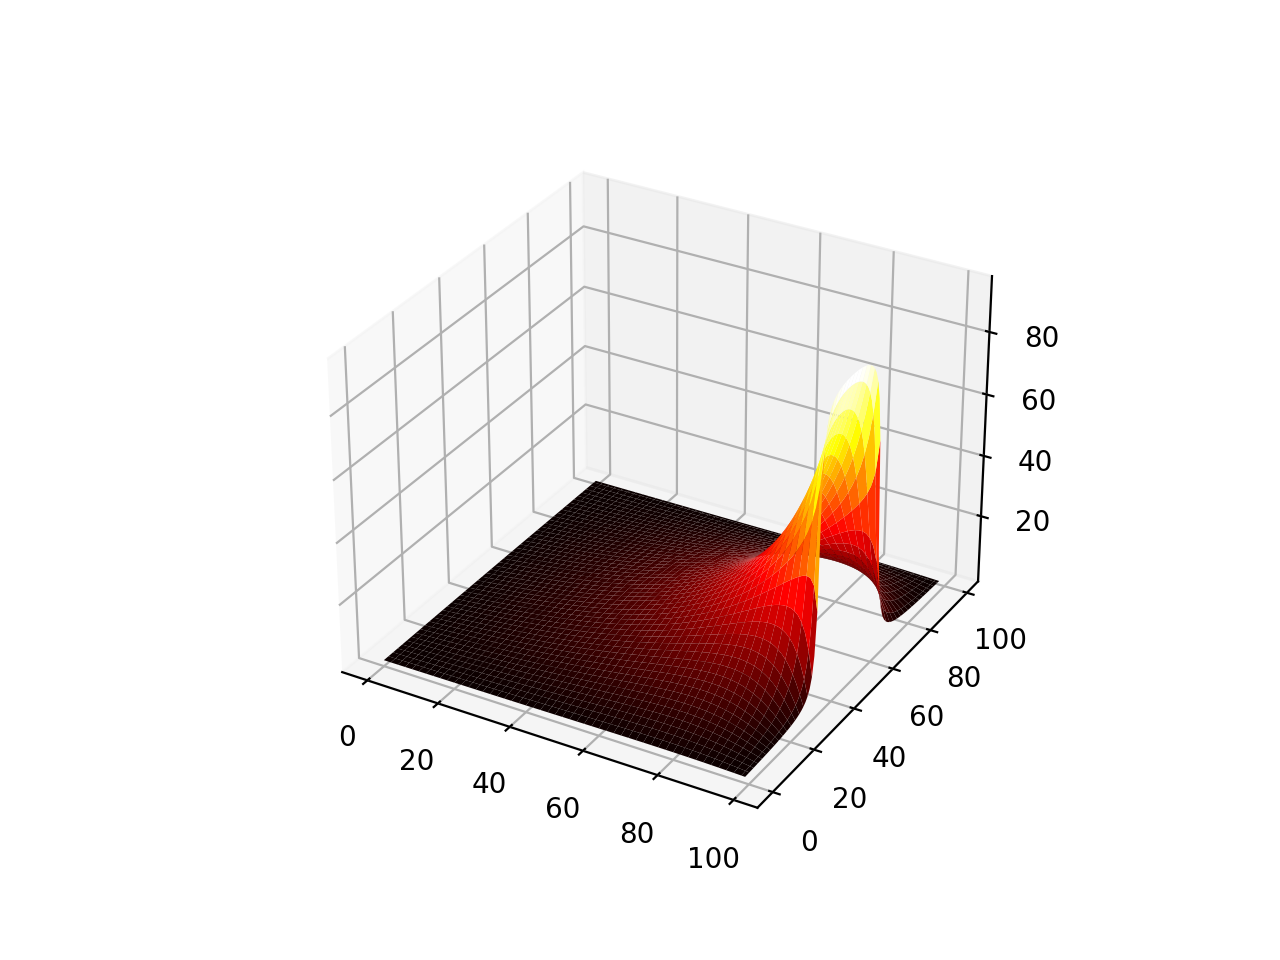

In [ ]:
# Try this for value of max_iters from 10 to 10000, and visualize them with the cell above

t, resvec = Jsolve(A, b, max_iters = 10000)

# Re-plot
T = t.reshape(k,k)
X, Y = np.meshgrid(range(k), range(k))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax = fig.gca()
ax.plot_surface(X, Y, T, cmap=cm.hot)

### Next with CG

<IPython.core.display.Javascript object>


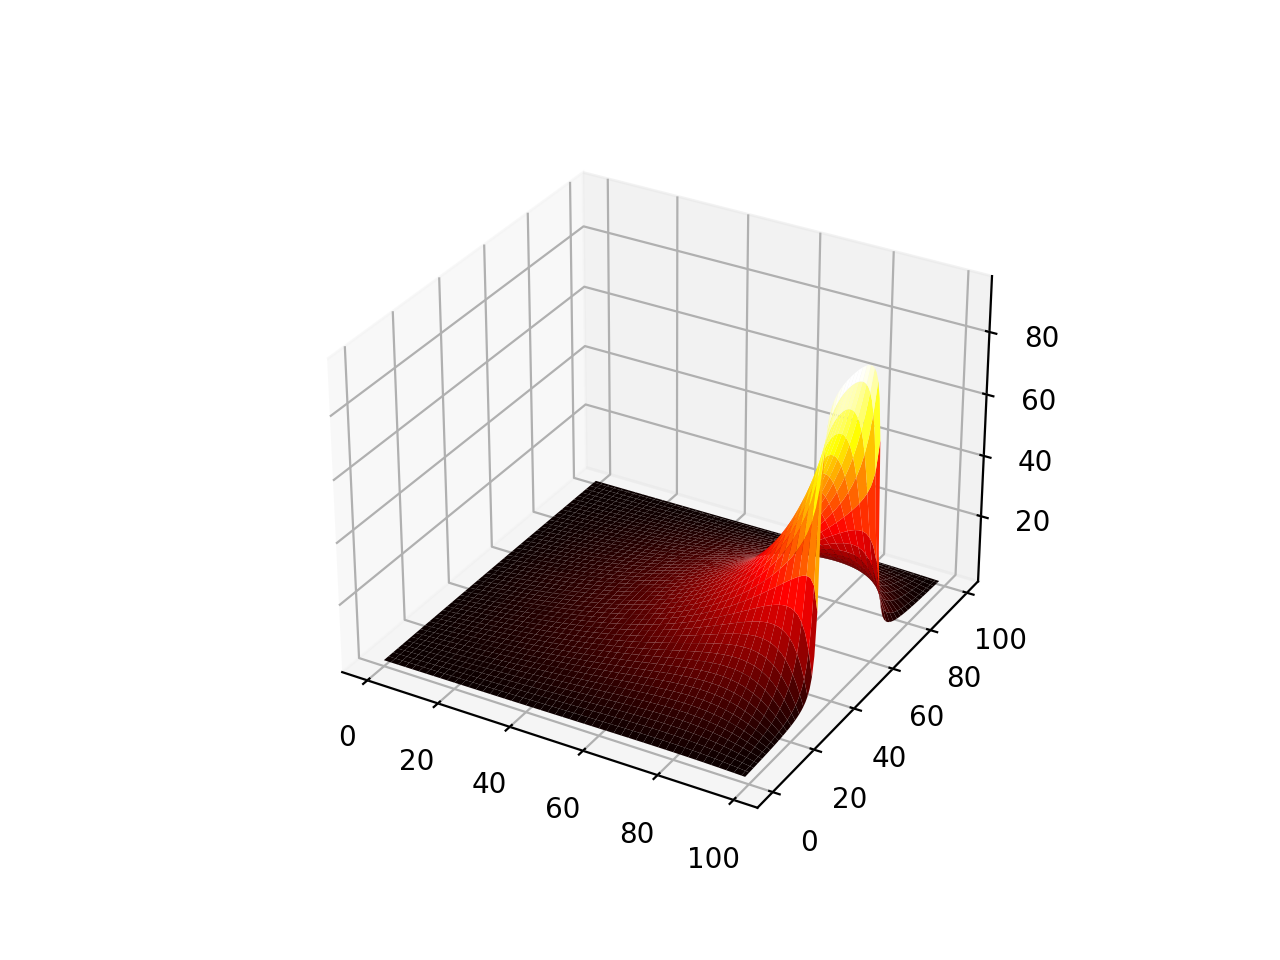

In [ ]:
# Try this for value of max_iters from 10 to 10000, and visualize them with the cell above

t, resvec = CGsolve(A, b, max_iters = 10000)

# Re-plot
T = t.reshape(k,k)
X, Y = np.meshgrid(range(k), range(k))
#%matplotlib tk
get_ipython().run_line_magic('matplotlib', 'tk')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax = fig.gca()
ax.plot_surface(X, Y, T, cmap=cm.hot)

### Comparing Jacobi vs CG


Jacobi iters: 1000
last rel res: 0.002944739488603501
computed rel res: 0.002944739488603501

CG iters: 311
last rel res: 9.564684758656541e-11
computed rel res: 9.564684758656541e-11


Text(0.5, 1.0, 'Iterative methods for temperature problem with n = 10000')

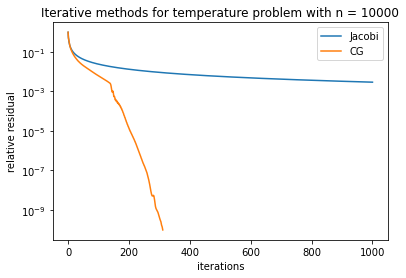

In [ ]:
# Plot relative residual (y axis) versus iteration number (x axis) for both Jacobi and CG

%matplotlib inline
plt.figure()

(xJ,resvecJ) = Jsolve(A, b, tol = 1e-10, max_iters = 1000)
print('\nJacobi iters:', len(resvecJ)-1)
print('last rel res:', resvecJ[-1])
print('computed rel res:', npla.norm(A@xJ - b) / npla.norm(b))
plt.semilogy(resvecJ, label = 'Jacobi')

(xCG,resvecCG) = CGsolve(A, b, tol = 1e-10, max_iters = 1000)
print('\nCG iters:', len(resvecCG)-1)
print('last rel res:', resvecCG[-1])
print('computed rel res:', npla.norm(A@xCG - b) / npla.norm(b))
plt.semilogy(resvecCG, label = 'CG')

plt.legend()
plt.xlabel('iterations')
plt.ylabel('relative residual')
plt.title('Iterative methods for temperature problem with n = %d' % A.shape[0])